In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
pd.set_option('display.max_columns', None)


In [2]:
incident1 = pd.read_csv("./../../Data/original/Incident_2009-2017.csv", dtype={'IncidentNumber': 'str'}, low_memory=False)
incident2 = pd.read_excel("./../../Data/original/Incident_2018-2024.xlsx", dtype={'IncidentNumber': 'str'})

mob1 = pd.read_excel("./../../Data/original/Mobilisation_2009-2014.xlsx")
mob2 = pd.read_excel("./../../Data/original/Mobilisation_2015-2020.xlsx")
mob3 = pd.read_excel("./../../Data/original/Mobilisation_2021-2024.xlsx")

In [53]:
incidents = pd.concat([incident1, incident2], axis = 0)

In [54]:
incidents.index = incidents['IncidentNumber']

In [56]:
incidents = incidents.drop(['IncidentNumber'], axis = 1)

In [57]:
incidents_preview = pd.concat([incidents.head(10), incidents.tail(10)])
incidents_preview.to_csv('incidents_prev.csv')

In [55]:
incidents.head()

,IncidentNumber,DateTimeCall,DeployedFromStation_Name,DeployedFromLocation,PlusCode_Description,IncidentGroup,StopCodeDescription,PropertyCategory,Postcode_district,IncGeo_BoroughName,...,Latitude,Longitude,FRS,FirstPumpArriving_AttendanceTime,SecondPumpArriving_AttendanceTime,SecondPumpArriving_DeployedFromStation,PumpCount,PumpMinutesRounded,Notional Cost (£),NumCalls
IncidentNumber,,,,,,,,,,,,,,,,,,,,,
235138081,235138081,2009-01-01 00:02:27,Battersea,0.0,Initial Mobilisation,Special Service,Special Service,Road Vehicle,SW11,WANDSWORTH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2091,2091,2009-01-01 00:04:09,Edmonton,0.0,Initial Mobilisation,Fire,Secondary Fire,Outdoor,N9,ENFIELD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3091,3091,2009-01-01 00:04:57,Hillingdon,0.0,Initial Mobilisation,Fire,Secondary Fire,Outdoor,UB10,HILLINGDON,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5091,5091,2009-01-01 00:06:04,Holloway,0.0,Initial Mobilisation,Fire,Secondary Fire,Outdoor,N7,ISLINGTON,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6091,6091,2009-01-01 00:06:30,Kentish Town,0.0,Initial Mobilisation,False Alarm,AFA,Dwelling,NW5,CAMDEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
dfs = [mob1, mob2, mob3]

# Filter out invalid DataFrames and remove all-NA columns from each DataFrame
valid_dfs = []
for df in dfs:
    if not df.empty:  # Ensure the DataFrame is not empty
        # Drop all-NA columns
        df = df.dropna(axis=1, how='all')
        if not df.isna().all().all():  # Ensure the DataFrame is not all-NA after column removal
            valid_dfs.append(df)

# Concatenate the filtered DataFrames
mobilisation = pd.concat(valid_dfs, axis=0)

In [19]:
mobilisation.index = mobilisation['IncidentNumber']

In [51]:
mobilisation_preview = pd.concat([mobilisation.head(10), mobilisation.tail(10)])
mobilisation_preview.to_csv('mob_prev.csv')

In [24]:
mobilisation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2373348 entries, 235138081 to 067903-30042024
Data columns (total 22 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   IncidentNumber            object        
 1   CalYear                   int64         
 2   HourOfCall                int64         
 3   ResourceMobilisationId    int64         
 4   Resource_Code             object        
 5   PerformanceReporting      object        
 6   DateAndTimeMobilised      datetime64[ns]
 7   DateAndTimeMobile         datetime64[ns]
 8   DateAndTimeArrived        datetime64[ns]
 9   TurnoutTimeSeconds        float64       
 10  TravelTimeSeconds         float64       
 11  AttendanceTimeSeconds     int64         
 12  DateAndTimeLeft           datetime64[ns]
 13  DateAndTimeReturned       datetime64[ns]
 14  DeployedFromStation_Code  object        
 15  DeployedFromStation_Name  object        
 16  DeployedFromLocation      object        
 1

In [22]:
# Convert 'DateOfCall' to datetime in incidents
incidents['DateOfCall'] = pd.to_datetime(incidents['DateOfCall'], format='%d-%b-%y')


In [63]:
df = pd.read_parquet('../data/df_cleaned_for_model.parquet')

In [65]:
filtered_columns = [col for col in df.columns if 'CellEastingNorthing' not in col]

# Print the filtered column names
print(filtered_columns)

['IncidentGroup_Fire', 'IncidentGroup_Special Service', 'AggregatedPropertyCategory_Outdoor', 'AggregatedPropertyCategory_Residential', 'AggregatedPropertyCategory_Vehicle', 'IsBankholiday', 'IsWeekend', 'DistanceStationLog', 'TotalResponseTimeLog', 'Hour_sin', 'Hour_cos', 'Weekday_sin', 'Weekday_cos', 'Month_sin', 'Month_cos']


In [67]:
df_without_geo = df[filtered_columns]

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_without_geo, df_without_geo['TotalResponseTimeLog'], test_size=0.2)

In [77]:
X_test.to_parquet('df_no_geo.parquet')

In [78]:
X_test.columns

Index(['IncidentGroup_Fire', 'IncidentGroup_Special Service',
       'AggregatedPropertyCategory_Outdoor',
       'AggregatedPropertyCategory_Residential',
       'AggregatedPropertyCategory_Vehicle', 'IsBankholiday', 'IsWeekend',
       'DistanceStationLog', 'TotalResponseTimeLog', 'Hour_sin', 'Hour_cos',
       'Weekday_sin', 'Weekday_cos', 'Month_sin', 'Month_cos'],
      dtype='object')

In [68]:
df_without_geo.to_parquet('df_no_geo.parquet')

In [79]:
#df_preview = pd.concat([df.head(10), df.tail(10)])
df_without_geo.to_parquet('df_no_geo.parquet')

In [68]:
print(combined_df['IncidentNumber'].duplicated().sum())
duplicates = combined_df[combined_df['IncidentNumber'].duplicated(keep=False)]

# Display duplicates
print(duplicates)

370304
          IncidentNumber DateOfCall  CalYear_inc TimeOfCall  HourOfCall_inc  \
3190     000026-01012018 2018-01-01         2018   00:13:57               0   
3191     000026-01012018 2018-01-01         2018   00:13:57               0   
3203     000048-01012018 2018-01-01         2018   00:33:31               0   
3204     000048-01012018 2018-01-01         2018   00:33:31               0   
3207     000052-01012018 2018-01-01         2018   00:39:31               0   
...                  ...        ...          ...        ...             ...   
1086490  067881-30042024 2024-04-30         2024   00:19:44               0   
1086491  067882-30042024 2024-04-30         2024   00:19:59               0   
1086492  067882-30042024 2024-04-30         2024   00:19:59               0   
1086506  067898-30042024 2024-04-30         2024   00:49:17               0   
1086507  067898-30042024 2024-04-30         2024   00:49:17               0   

           IncidentGroup        StopCodeDesc

In [70]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 672347 entries, 3183 to 1086511
Data columns (total 60 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   IncidentNumber                          672347 non-null  object        
 1   DateOfCall                              672347 non-null  datetime64[ns]
 2   CalYear_x                               672347 non-null  int64         
 3   TimeOfCall                              672347 non-null  object        
 4   HourOfCall_x                            672347 non-null  int64         
 5   IncidentGroup                           672347 non-null  object        
 6   StopCodeDescription                     672347 non-null  object        
 7   SpecialServiceType                      213127 non-null  object        
 8   PropertyCategory                        672347 non-null  object        
 9   PropertyType                          

In [60]:
combined_df.head()

,IncidentNumber,DateOfCall,CalYear_x,TimeOfCall,HourOfCall_x,IncidentGroup,StopCodeDescription,SpecialServiceType,PropertyCategory,PropertyType,...,DateAndTimeLeft,DateAndTimeReturned,DeployedFromStation_Code,DeployedFromStation_Name,DeployedFromLocation,PumpOrder,PlusCode_Code,PlusCode_Description,DelayCodeId,DelayCode_Description
0,235138081.00,2009-01-01,2009,00:00:37,0,Special Service,Special Service,RTC,Road Vehicle,Car,...,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1091.00,2009-01-01,2009,00:00:46,0,Special Service,Special Service,Assist other agencies,Outdoor,Lake/pond/reservoir,...,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2091.00,2009-01-01,2009,00:03:00,0,Fire,Secondary Fire,NaN,Outdoor,Road surface/pavement,...,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3091.00,2009-01-01,2009,00:04:27,0,Fire,Secondary Fire,NaN,Outdoor,Domestic garden (vegetation not equipment),...,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5091.00,2009-01-01,2009,00:05:39,0,Fire,Secondary Fire,NaN,Outdoor,Cycle path/public footpath/bridleway,...,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
combined_df = combined_df.loc[combined_df.PumpOrder == 1].copy()

In [72]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 672347 entries, 3183 to 1086511
Data columns (total 60 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   IncidentNumber                          672347 non-null  object        
 1   DateOfCall                              672347 non-null  datetime64[ns]
 2   CalYear_inc                             672347 non-null  int64         
 3   TimeOfCall                              672347 non-null  object        
 4   HourOfCall_inc                          672347 non-null  int64         
 5   IncidentGroup                           672347 non-null  object        
 6   StopCodeDescription                     672347 non-null  object        
 7   SpecialServiceType                      213127 non-null  object        
 8   PropertyCategory                        672347 non-null  object        
 9   PropertyType                          

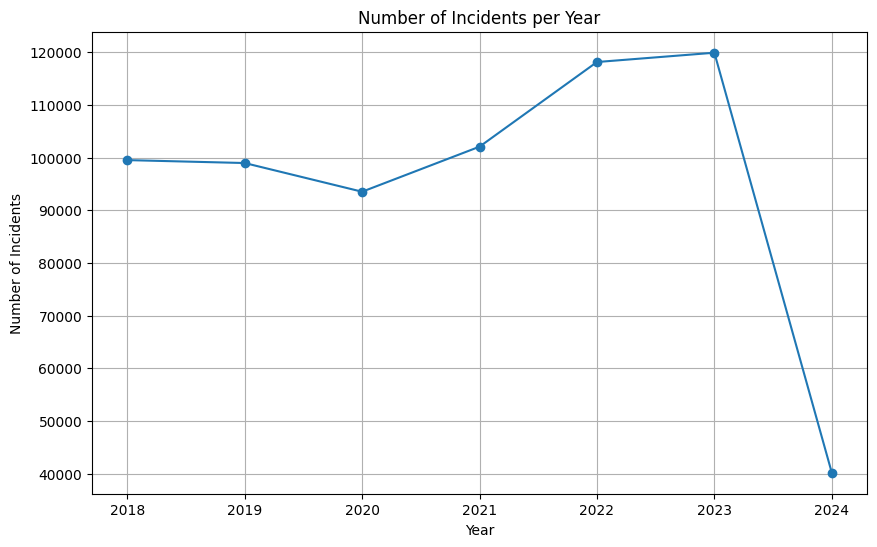

In [49]:
# Example: Number of incidents per year
df['DateOfCall'] = pd.to_datetime(df['DateOfCall'])
df['Year'] = df['DateOfCall'].dt.year
incidents_per_year = df.groupby('Year').size()

plt.figure(figsize=(10, 6))
plt.plot(incidents_per_year.index, incidents_per_year.values, marker='o')
plt.title('Number of Incidents per Year')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.grid(True)
plt.show()